# Combinatorial Optimization with Physics-Inspired Graph Neural Networks

In this notebook we show how to solve combinatorial optimization problems with physics-inspired graph neural networks, as outlined in M. J. A. Schuetz, J. K. Brubaker, H. G. Katzgraber, _Combinatorial Optimization with Physics-Inspired Graph Neural Networks_, [arXiv:2107.01188](https://arxiv.org/abs/2107.01188). 
Here we focus on the canonical maximum independent set (MIS) problem, but our approach can easily be extended to other combinatorial optimization problems. 
For the actual implementation of the graph neural network we use the open-source ```dgl``` library. 

Please note we have provided a `requirements.txt` file, which defines the environment required to run this code. Because some of the packages are not available on default OSX conda channels, we have also provided suggested channels to find them on. These can be distilled into a single line as such:

> conda create -n \<environment_name\> python=3 --file requirements.txt -c conda-forge -c dglteam -c pytorch

In [1]:
import dgl
import torch
import random
import os
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F

from collections import OrderedDict, defaultdict
from dgl.nn.pytorch import GraphConv
from itertools import chain, islice, combinations
from networkx.algorithms.approximation.independent_set import maximum_independent_set as mis
from time import time

# MacOS can have issues with MKL. For more details, see
# https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Using backend: pytorch


In [2]:
# fix seed to ensure consistent results
seed_value = 1
random.seed(seed_value)        # seed python RNG
np.random.seed(seed_value)     # seed global NumPy RNG
torch.manual_seed(seed_value)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


# Step 0 - Define utility functions

We first load a few general utility functions from ```utils.py``` before defining some helper functions specific to the MIS problem. 

### General utilities

In [3]:
from utils import generate_graph, get_gnn, run_gnn_training, qubo_dict_to_torch, gen_combinations, loss_func

### Problem-specific (MIS) utilities

In [4]:
# helper function to generate Q matrix for Maximum Independent Set problem (MIS)
def gen_q_dict_mis(nx_G, penalty=2):
    """
    Helper function to generate QUBO matrix for MIS as minimization problem.
    
    Input:
        nx_G: graph as networkx graph object (assumed to be unweigthed)
    Output:
        Q_dic: QUBO as defaultdict
    """

    # Initialize our Q matrix
    Q_dic = defaultdict(int)

    # Update Q matrix for every edge in the graph
    # all off-diagonal terms get penalty
    for (u, v) in nx_G.edges:
        Q_dic[(u, v)] = penalty

    # all diagonal terms get -1
    for u in nx_G.nodes:
        Q_dic[(u, u)] = -1

    return Q_dic


# Run classical MIS solver (provided by NetworkX)
def run_mis_solver(nx_graph):
    """
    helper function to run traditional solver for MIS.
    
    Input:
        nx_graph: networkx Graph object
    Output:
        ind_set_bitstring_nx: bitstring solution as list
        ind_set_nx_size: size of independent set (int)
        number_violations: number of violations of ind.set condition
    """
    # compare with traditional solver
    t_start = time()
    ind_set_nx = mis(nx_graph)
    t_solve = time() - t_start
    ind_set_nx_size = len(ind_set_nx)

    # get bitstring list
    nx_bitstring = [1 if (node in ind_set_nx) else 0 for node in sorted(list(nx_graph.nodes))]
    edge_set = set(list(nx_graph.edges))

    # Updated to be able to handle larger scale
    print('Calculating violations...')
    # check for violations
    number_violations = 0
    for ind_set_chunk in gen_combinations(combinations(ind_set_nx, 2), 100000):
        number_violations += len(set(ind_set_chunk).intersection(edge_set))

    return nx_bitstring, ind_set_nx_size, number_violations, t_solve


# Calculate results given bitstring and graph definition, includes check for violations
def postprocess_gnn_mis(best_bitstring, nx_graph):
    """
    helper function to postprocess MIS results

    Input:
        best_bitstring: bitstring as torch tensor
    Output:
        size_mis: Size of MIS (int)
        ind_set: MIS (list of integers)
        number_violations: number of violations of ind.set condition
    """

    # get bitstring as list
    bitstring_list = list(best_bitstring)

    # compute cost
    size_mis = sum(bitstring_list)

    # get independent set
    ind_set = set([node for node, entry in enumerate(bitstring_list) if entry == 1])
    edge_set = set(list(nx_graph.edges))

    print('Calculating violations...')
    # check for violations
    number_violations = 0
    for ind_set_chunk in gen_combinations(combinations(ind_set, 2), 100000):
        number_violations += len(set(ind_set_chunk).intersection(edge_set))

    return size_mis, ind_set, number_violations

# Step 1 - Set hyperparameters

In [5]:
# Graph hypers
n = 100
d = 3
p = None
graph_type = 'reg'

# NN learning hypers #
number_epochs = int(1e5)
learning_rate = 1e-4
PROB_THRESHOLD = 0.5

# Early stopping to allow NN to train to near-completion
tol = 1e-4          # loss must change by more than tol, or trigger
patience = 100    # number early stopping triggers before breaking loop

# Problem size (e.g. graph size)
n = 100

# Establish dim_embedding and hidden_dim values
dim_embedding = int(np.sqrt(n))    # e.g. 10
hidden_dim = int(dim_embedding/2)  # e.g. 5

# Step 2 - Generate random graph

In [6]:
# Constructs a random d-regular or p-probabilistic graph
nx_graph = generate_graph(n=n, d=d, p=p, graph_type=graph_type, random_seed=seed_value)
# get DGL graph from networkx graph, load onto device
graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)

# Construct Q matrix for graph
q_torch = qubo_dict_to_torch(nx_graph, gen_q_dict_mis(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

Generating d-regular graph with n=100, d=3, seed=1


In [7]:
# Visualize graph
pos = nx.kamada_kawai_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])

# Step 3 - Set up optimizer/GNN architecture

In [8]:
# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 1,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)

# Step 4 - Run GNN training

In [9]:
print('Running GNN...')
gnn_start = time()

_, epoch, final_bitstring, best_bitstring = run_gnn_training(
    q_torch, graph_dgl, net, embed, optimizer, gnn_hypers['number_epochs'],
    gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'])

gnn_time = time() - gnn_start

Running GNN...
Epoch: 0, Loss: 44.26842498779297
Epoch: 1000, Loss: 16.77007293701172
Epoch: 2000, Loss: 5.100368022918701
Epoch: 3000, Loss: 1.3506901264190674
Epoch: 4000, Loss: -0.5503950119018555
Epoch: 5000, Loss: -3.9807755947113037
Epoch: 6000, Loss: -12.856514930725098
Epoch: 7000, Loss: -23.30199432373047
Epoch: 8000, Loss: -32.843528747558594
Epoch: 9000, Loss: -38.91016387939453
Epoch: 10000, Loss: -41.560691833496094
Epoch: 11000, Loss: -42.45568084716797
Epoch: 12000, Loss: -42.753623962402344
Stopping early on epoch 12959 (patience: 100)
GNN training (n=100) took 40.649
GNN final continuous loss: -42.87350082397461
GNN best continuous loss: -42.87350082397461


# Step 5 - Post-process GNN results

In [10]:
final_loss = loss_func(final_bitstring.float(), q_torch)
final_bitstring_str = ','.join([str(x) for x in final_bitstring])

# Process bitstring reported by GNN
size_mis, ind_set, number_violations = postprocess_gnn_mis(best_bitstring, nx_graph)
gnn_tot_time = time() - gnn_start

print(f'Independence number found by GNN is {size_mis} with {number_violations} violations')
print(f'Took {round(gnn_tot_time, 3)}s, model training took {round(gnn_time, 3)}s')

Calculating violations...
Independence number found by GNN is 43 with 0 violations
Took 40.722s, model training took 40.661s


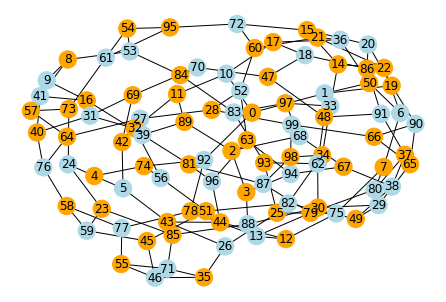

In [11]:
# Visualize result
# Note no light-blue nodes are connected by an edge
color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph, pos, with_labels=True, node_color=color_map)

# Step 6 - (optional) Compare to classical solver

In [12]:
# run solver
print(f'Running built-in MIS solver (n={n}).')
start = time()
ind_set_bitstring_nx, ind_set_nx_size, nx_number_violations, t_solve = run_mis_solver(nx_graph)
end = time()
runtime_sol = end - start
print(f'Independence number found by nx solver is {ind_set_nx_size} with {nx_number_violations} violations.')
print(f'MIS solver took {round(runtime_sol, 3)}s')

Running built-in MIS solver (n=100).
Calculating violations...
Independence number found by nx solver is 39 with 0 violations.
MIS solver took 0.597s
